In [2]:
!pip install torchsummary

In [3]:
!pip install -U tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-cv 0.8.2 requires keras-core, which is not installed.
keras-nlp 0.8.1 requires keras-core, which is not installed.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.1.2 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.

In [4]:
import torch
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm_notebook

import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

2024-03-14 16:11:40.249587: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 16:11:40.249715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 16:11:40.399953: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data analysis

In [5]:
data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

In [6]:
data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [7]:
data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
data['keyword'].value_counts()

keyword
fatalities               45
armageddon               42
deluge                   42
harm                     41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

In [9]:
data['keyword'] = data['keyword'].fillna('fatalities')

In [10]:
data['location'].value_counts()

location
USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
Some pum pum             1
Paulton, England         1
SEA Server               1
todaysbigstock.com       1
???????? ?????????.      1
Name: count, Length: 3341, dtype: int64

In [11]:
data['location'] = data['location'].fillna('USA')

In [12]:
data

,id,keyword,location,text,target
0,1,fatalities,USA,Our Deeds are the Reason of this #earthquake M...,1
1,4,fatalities,USA,Forest fire near La Ronge Sask. Canada,1
2,5,fatalities,USA,All residents asked to 'shelter in place' are ...,1
3,6,fatalities,USA,"13,000 people receive #wildfires evacuation or...",1
4,7,fatalities,USA,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,fatalities,USA,Two giant cranes holding a bridge collapse int...,1
7609,10870,fatalities,USA,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,fatalities,USA,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,fatalities,USA,Police investigating after an e-bike collided ...,1


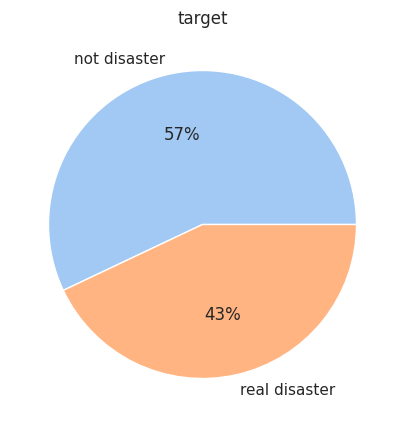

In [13]:
sns.set(rc={'figure.figsize': (5, 5)})
colors = sns.color_palette('pastel')[0:5]
labels = sorted(data['target'].map(str).replace('1', 'real disaster').replace('0', 'not disaster').unique())
dt = np.array([len(data[data['target'].map(str).replace('1', 'real disaster').replace('0', 'not disaster') == i]) for i in labels])
plt.pie(dt, labels=labels, colors=colors, autopct='%.0f%%')
plt.title('target')
plt.show()

# Setting up the tokenizer

In [14]:
data['shuf_text'] = list(map(lambda x: ' '.join(x), data[['keyword', 'location', 'text']].values))

In [15]:
data

,id,keyword,location,text,target,shuf_text
0,1,fatalities,USA,Our Deeds are the Reason of this #earthquake M...,1,fatalities USA Our Deeds are the Reason of thi...
1,4,fatalities,USA,Forest fire near La Ronge Sask. Canada,1,fatalities USA Forest fire near La Ronge Sask....
2,5,fatalities,USA,All residents asked to 'shelter in place' are ...,1,fatalities USA All residents asked to 'shelter...
3,6,fatalities,USA,"13,000 people receive #wildfires evacuation or...",1,"fatalities USA 13,000 people receive #wildfire..."
4,7,fatalities,USA,Just got sent this photo from Ruby #Alaska as ...,1,fatalities USA Just got sent this photo from R...
...,...,...,...,...,...,...
7608,10869,fatalities,USA,Two giant cranes holding a bridge collapse int...,1,fatalities USA Two giant cranes holding a brid...
7609,10870,fatalities,USA,@aria_ahrary @TheTawniest The out of control w...,1,fatalities USA @aria_ahrary @TheTawniest The o...
7610,10871,fatalities,USA,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,fatalities USA M1.94 [01:04 UTC]?5km S of Volc...
7611,10872,fatalities,USA,Police investigating after an e-bike collided ...,1,fatalities USA Police investigating after an e...


In [16]:
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [17]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [18]:
test['location'].value_counts()

location
New York                    38
USA                         37
Worldwide                   16
United States               15
London                      13
                            ..
Twin Falls, Idaho, 83301     1
Oakland, Ca                  1
/ Kattappana, Kerala         1
Woodbridge, VA               1
USA,Washington,Seattle       1
Name: count, Length: 1602, dtype: int64

In [19]:
test['keyword'].value_counts()

keyword
deluged          23
rubble           22
demolished       22
obliteration     21
annihilation     21
                 ..
fatalities        5
threat            5
forest%20fire     5
inundation        4
epicentre         1
Name: count, Length: 221, dtype: int64

In [20]:
test['location'] = test['location'].fillna('New York')
test['keyword'] = test['keyword'].fillna('deluged')

In [21]:
test['shuf_text'] = list(map(lambda x: ' '.join(x), test[['keyword', 'location', 'text']].values))

In [22]:
texts = data['shuf_text'].to_list() + test['shuf_text'].to_list()
print('max len symbols', max(map(lambda x: len(x), texts)))
print('max len text', max(map(lambda x: len(x.split()), texts)))
text_set = []
for i in texts:
    text_set.extend(i.split())
print('max count words', len(set(text_set)))

max len symbols 195
max len text 36
max count words 45802


In [23]:
maxWordsCount = 45802
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!–"—#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n\r«»', lower=True, split=' ', char_level=False)
tokenizer.fit_on_texts(texts)

In [24]:
data_tk = tokenizer.texts_to_sequences(data['shuf_text'].to_list())
data_pad = pad_sequences(data_tk, maxlen=36)

# Train test split

In [25]:
X = np.array(data_pad)
Y = data['target'].to_numpy()

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.1, random_state=42)

In [26]:
X_train = torch.tensor(X_train)#.float()
Y_train = torch.tensor(Y_train)#.float()

X_valid = torch.tensor(X_valid)#.float()
Y_valid = torch.tensor(Y_valid)#.float()

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([6851, 36]),
 torch.Size([6851]),
 torch.Size([762, 36]),
 torch.Size([762]))

In [27]:
class Data_Disaster_Tweets(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.Y[i]

In [28]:
train_data = Data_Disaster_Tweets(X_train, Y_train)
valid_data = Data_Disaster_Tweets(X_valid, Y_valid)

In [29]:
train_data, valid_data

(<__main__.Data_Disaster_Tweets at 0x7cbeaa2e5810>,
 <__main__.Data_Disaster_Tweets at 0x7cbeaa2e5450>)

In [30]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)

In [31]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print('X_batch')
    print(x_batch.size())
    print(x_batch)
    print()
    
    print('Y_batch')
    print(y_batch.size())
    print(y_batch)
    print()
    break

X_batch
torch.Size([32, 36])
tensor([[    0,     0,     0,  ..., 23181,    54,  9153],
        [    0,     0,     0,  ...,   561,   401,  1679],
        [    0,     0,     0,  ...,  2098,     8,   243],
        ...,
        [    0,     0,     0,  ...,   108,    55,   259],
        [    0,     0,     0,  ...,     1,     2, 10444],
        [    0,     0,     0,  ...,     1,     2, 20859]], device='cuda:0',
       dtype=torch.int32)

Y_batch
torch.Size([32])
tensor([0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')



# Fit model

## Model

In [311]:
class Net_Disaster_Tweets(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout, n_layers, max_len_text):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.max_len_text = max_len_text
        self.hidden_dim_after_flat = self.hidden_dim * self.max_len_text
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm_1 = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           batch_first=True,
                           dropout=dropout)
        self.lstm_2 = nn.LSTM(hidden_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           batch_first=True,
                           dropout=dropout)
        
        self.flaten = nn.Flatten()
        self.fc_after_flat = nn.Linear(self.hidden_dim_after_flat, hidden_dim)
        
        self.fc1_1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc1_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc1_3 = nn.Linear(hidden_dim, hidden_dim)    
        
        self.fc2 = nn.Linear(hidden_dim, 2)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        x = self.embedding(text)
        
        if torch.cuda.is_available():
            h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim, device=torch.device('cuda:0')).float()
            c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim, device=torch.device('cuda:0')).float()
        else:
            h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim)
            c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim)
        x, _ = self.lstm_1(x, (h0, c0))
#         print(x.size())

        if torch.cuda.is_available():
            h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim, device=torch.device('cuda:0')).float()
            c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim, device=torch.device('cuda:0')).float()
        else:
            h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim)
            c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim)
        x, _ = self.lstm_2(x, (h0, c0))
#         print(x.size())
        
        x = self.flaten(x)
        
        if torch.cuda.is_available():
            x = F.relu(self.fc_after_flat(x))
        else:
            hid_after_flat = self.hidden_dim * (x.shape[-1] // self.hidden_dim)
            x = F.relu(self.fc_after_flat(x))
        x = F.relu(self.fc1_1(x))
        x = F.relu(self.fc1_2(x))
        x = F.relu(self.fc1_3(x))
        
        x = self.dropout(self.fc2(x))
        return x

In [312]:
EMBEDDING_DIM = 512
HIDDEN_DIM = 256
DROPOUT = 0.35
N_LAYERS = 2
max_len_text=36

In [313]:
model = Net_Disaster_Tweets(
    vocab_size=maxWordsCount,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    dropout=DROPOUT,
    n_layers=N_LAYERS,
    max_len_text=max_len_text
)
model

Net_Disaster_Tweets(
  (embedding): Embedding(45802, 512)
  (lstm_1): LSTM(512, 256, num_layers=2, batch_first=True, dropout=0.35)
  (lstm_2): LSTM(256, 256, num_layers=2, batch_first=True, dropout=0.35)
  (flaten): Flatten(start_dim=1, end_dim=-1)
  (fc_after_flat): Linear(in_features=9216, out_features=256, bias=True)
  (fc1_1): Linear(in_features=256, out_features=256, bias=True)
  (fc1_2): Linear(in_features=256, out_features=256, bias=True)
  (fc1_3): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.35, inplace=False)
)

In [314]:
# model(torch.tensor((data_pad[:5])).to(device))

## fit

In [315]:
model.to(device) #CNN to GPU
learning_rate = 3e-6

# Loss and optimizer
loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [316]:
def binary_accuracy(preds, y):

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
#     print(torch.max(preds, 1)[-1])
    correct = (torch.max(preds, 1)[-1] == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [317]:
def train_one_epoch(model, data_loader, loss_function, optimizer, num_ep):
    global device
    model.train()
    loss_dt = []
    accur = []
    for batch_index, batch in enumerate(tqdm_notebook(data_loader)):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
#         print(x_batch)
        
        optimizer.zero_grad()
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        loss_dt.append(loss.item())
        accur.append(binary_accuracy(output, y_batch))
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
    print(f'Epoch train: {num_ep + 1}, loss train: {np.mean(np.array(loss_dt))}, {np.max(np.array(loss_dt))}, {np.min(np.array(loss_dt))}')
    return np.mean(np.array(loss_dt)), accur

In [318]:
def validation_one_epoch(model, data_loader, loss_function):
    global device
    model.eval()
    loss_dt = []
    accur = []
    for batch_index, batch in enumerate(tqdm_notebook(data_loader)):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            loss_dt.append(loss.item())
            accur.append(binary_accuracy(output, y_batch))
    print(f'Loss validation: {np.mean(np.array(loss_dt))}')
    return np.mean(np.array(loss_dt)), accur

In [319]:
epoches = 64

train_losses = []
train_acc = []

valid_losses = []
valid_acc = []
for epoch in range(epoches):
    losses, acc = train_one_epoch(model, train_loader, loss_function, optimizer, epoch)
    train_losses.append(losses)
#     print(acc)
    train_acc.append(np.mean(np.array([float(i) for i in acc])))
    
    losses, acc = validation_one_epoch(model, valid_loader, loss_function)
    valid_losses.append(losses)
    valid_acc.append(np.mean(np.array([float(i) for i in acc])))

/tmp/ipykernel_34/3574187839.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_index, batch in enumerate(tqdm_notebook(data_loader)):


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 1, loss train: 0.7042161037755567, 0.7409667372703552, 0.6645049452781677


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.6992895950873693


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 2, loss train: 0.6943503410317177, 0.7259117364883423, 0.6587816476821899


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.6865387683113416


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 3, loss train: 0.6835152226825093, 0.7631277441978455, 0.6325578689575195


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.6811082114775976


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 4, loss train: 0.6792398987814438, 0.7450407147407532, 0.6274890303611755


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.6796569799383482


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 5, loss train: 0.6786230638969776, 0.756132185459137, 0.6014394760131836


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.6780927975972494


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 6, loss train: 0.6776221402855807, 0.7522012591362, 0.6150856614112854


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.676848774154981


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 7, loss train: 0.6736963746159575, 0.7508175373077393, 0.6102567911148071


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.674549234410127


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 8, loss train: 0.6740333471187325, 0.760513424873352, 0.5930157899856567


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.6725641513864199


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 9, loss train: 0.6697633978932402, 0.7690429091453552, 0.37100422382354736


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.6706218843658766


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 10, loss train: 0.6686712528384009, 0.7668484449386597, 0.5552678108215332


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.6690712223450342


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 11, loss train: 0.6670426657033521, 0.7835795879364014, 0.5796249508857727


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.666563001771768


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 12, loss train: 0.6657819138016812, 0.7931051850318909, 0.541430652141571


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.6650634855031967


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 13, loss train: 0.6594697270282479, 0.7934174537658691, 0.5681841969490051


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.6598942031462988


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 14, loss train: 0.6564046610233396, 0.7681111693382263, 0.5589919686317444


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.654328964650631


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 15, loss train: 0.6456608521383862, 0.8533152341842651, 0.4368384778499603


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.6450789545973142


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 16, loss train: 0.6409607598947924, 0.8266984820365906, 0.5014868378639221


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.6344013611475626


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 17, loss train: 0.624724615313286, 0.8347665071487427, 0.4366634786128998


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.617848681906859


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 18, loss train: 0.6067755694999252, 0.8191943764686584, 0.1822487711906433


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5997236395875613


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 19, loss train: 0.5920667922774027, 0.7870352268218994, 0.4191504418849945


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.589868446191152


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 20, loss train: 0.5885115899318872, 0.8373944163322449, 0.41257205605506897


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5751329610745112


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 21, loss train: 0.5740728098292683, 0.860649824142456, 0.398004949092865


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5682474747300148


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 22, loss train: 0.5697032873020615, 0.9150785803794861, 0.38757967948913574


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.560316126793623


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 23, loss train: 0.5571081082488215, 0.8305358290672302, 0.3270522356033325


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.554764581223329


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 24, loss train: 0.5579761165519094, 0.8779463768005371, 0.36494874954223633


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5490672091643015


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 25, loss train: 0.5481906603935153, 0.8456015586853027, 0.1728258728981018


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5454612697164217


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 26, loss train: 0.5422302967587183, 0.8468159437179565, 0.20548509061336517


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5413712983330091


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 27, loss train: 0.5374009323674579, 0.8055629134178162, 0.3277577757835388


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5375837050378323


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 28, loss train: 0.5334275356558866, 0.7476459741592407, 0.3534460961818695


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5349571990470091


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 29, loss train: 0.5392905371133672, 1.693783164024353, 0.34291723370552063


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5330808311700821


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 30, loss train: 0.5279827335546183, 0.8329809904098511, 0.341447114944458


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5322695759435495


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 31, loss train: 0.5264589579992516, 0.7999944090843201, 0.3323673903942108


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5271606296300888


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 32, loss train: 0.5248828521994657, 0.8284971714019775, 0.3327566683292389


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5308701532582442


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 33, loss train: 0.5151900460553723, 0.8180651664733887, 0.32637807726860046


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5226807023088137


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 34, loss train: 0.5119432840236398, 0.8103668093681335, 0.27948394417762756


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5262186663846175


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 35, loss train: 0.5092403817661973, 0.7755764722824097, 0.11204024404287338


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5188947841525078


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 36, loss train: 0.5049183496209078, 0.7960790991783142, 0.33377325534820557


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.518598847091198


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 37, loss train: 0.5028106116971304, 0.7930153012275696, 0.3335378170013428


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5170219428837299


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 38, loss train: 0.5032368618388509, 0.9325680732727051, 0.24832725524902344


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5147219188511372


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 39, loss train: 0.4942360605611358, 0.802039384841919, 0.23734386265277863


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5169365741312504


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 40, loss train: 0.4986030814259551, 0.7270702123641968, 0.3172668516635895


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5165186909337839


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 41, loss train: 0.48517629656680794, 0.7837843298912048, 0.2877764403820038


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5114694312214851


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 42, loss train: 0.48731861100640406, 0.7763513326644897, 0.31028813123703003


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5101032368838787


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 43, loss train: 0.48358432165412013, 0.7268509268760681, 0.2784467041492462


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5085273273289204


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 44, loss train: 0.4827990172907364, 0.7477829456329346, 0.12770646810531616


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5112563769022623


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 45, loss train: 0.48632021698840827, 0.7734888195991516, 0.27501407265663147


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5150941796600819


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 46, loss train: 0.4767506756061731, 0.8889619708061218, 0.26291170716285706


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5176879018545151


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 47, loss train: 0.4816269788631173, 1.0605597496032715, 0.27576830983161926


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5128223287562529


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 48, loss train: 0.4721321082738943, 0.8518640398979187, 0.09551656991243362


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5058129367729028


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 49, loss train: 0.47098753355270206, 0.7533770799636841, 0.26708507537841797


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5054278559982777


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 50, loss train: 0.4697752583858579, 0.7933995127677917, 0.24658694863319397


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5059598051011562


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 51, loss train: 0.4689292003249013, 0.8235151767730713, 0.24553392827510834


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.516762246688207


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 52, loss train: 0.46678396671317346, 1.0470868349075317, 0.22375495731830597


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5059494835635027


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 53, loss train: 0.4624463573184817, 0.8420185446739197, 0.02995407022535801


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.505247720827659


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 54, loss train: 0.46307165518749593, 0.9652009010314941, 0.24640516936779022


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5143735135595003


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 55, loss train: 0.4512718087018922, 0.7968524098396301, 0.21104630827903748


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5086343040068945


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 56, loss train: 0.4579324428425279, 0.9710902571678162, 0.203810453414917


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5048760262628397


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 57, loss train: 0.4521494657494301, 0.9362709522247314, 0.2599634826183319


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5047336891293526


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 58, loss train: 0.4537071020104164, 1.2330840826034546, 0.26519352197647095


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5124850186208884


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 59, loss train: 0.44910877589569537, 0.8251749277114868, 0.21535317599773407


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5032175580660502


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 60, loss train: 0.4482036900381709, 0.773505449295044, 0.22687070071697235


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5049867381652197


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 61, loss train: 0.43632373497929683, 0.6956539750099182, 0.22196370363235474


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5055439037581285


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 62, loss train: 0.4359370806016201, 0.6860633492469788, 0.06019925698637962


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5074753848214945


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 63, loss train: 0.44438988711944843, 0.8455095887184143, 0.24613423645496368


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5071082636713982


  0%|          | 0/215 [00:00<?, ?it/s]

Epoch train: 64, loss train: 0.4391039416540501, 0.9077825546264648, 0.24660919606685638


  0%|          | 0/24 [00:00<?, ?it/s]

Loss validation: 0.5081224118669828


Text(0.5, 1.0, 'Accuracy')

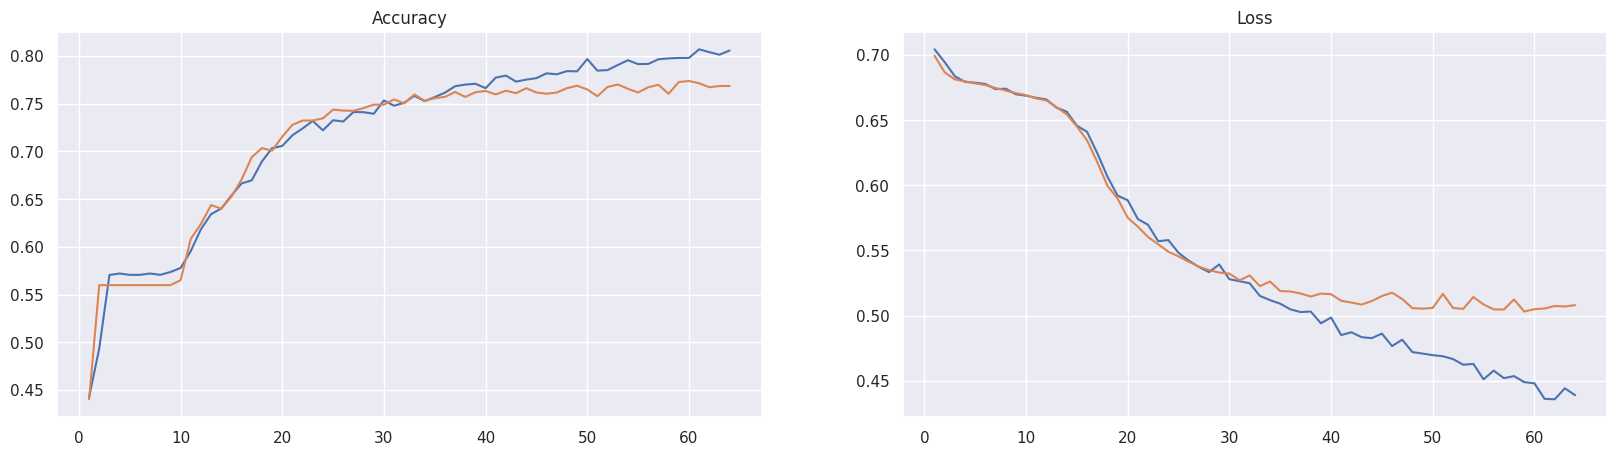

In [320]:
plt.figure(figsize=(20, 5))
# N = np.arange(0, EPOCHS)

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label="train_loss")
plt.plot(np.arange(1, len(valid_losses) + 1), valid_losses, label="vall_loss")
plt.title("Loss")

plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(train_acc) + 1), train_acc, label="train_acc")
plt.plot(np.arange(1, len(valid_acc) + 1), valid_acc, label="val_acc")
plt.title("Accuracy")

# Predict test

In [329]:
test

,id,keyword,location,text,shuf_text
0,0,deluged,New York,Just happened a terrible car crash,deluged New York Just happened a terrible car ...
1,2,deluged,New York,"Heard about #earthquake is different cities, s...",deluged New York Heard about #earthquake is di...
2,3,deluged,New York,"there is a forest fire at spot pond, geese are...",deluged New York there is a forest fire at spo...
3,9,deluged,New York,Apocalypse lighting. #Spokane #wildfires,deluged New York Apocalypse lighting. #Spokane...
4,11,deluged,New York,Typhoon Soudelor kills 28 in China and Taiwan,deluged New York Typhoon Soudelor kills 28 in ...
...,...,...,...,...,...
3258,10861,deluged,New York,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,deluged New York EARTHQUAKE SAFETY LOS ANGELES...
3259,10865,deluged,New York,Storm in RI worse than last hurricane. My city...,deluged New York Storm in RI worse than last h...
3260,10868,deluged,New York,Green Line derailment in Chicago http://t.co/U...,deluged New York Green Line derailment in Chic...
3261,10874,deluged,New York,MEG issues Hazardous Weather Outlook (HWO) htt...,deluged New York MEG issues Hazardous Weather ...


In [330]:
test_tk = tokenizer.texts_to_sequences(test['shuf_text'].to_list())
test_pad = pad_sequences(test_tk, maxlen=36)

In [331]:
torch.max(model(torch.tensor((test_pad)).to(device)), 1)[-1]

tensor([0, 0, 0,  ..., 1, 0, 0], device='cuda:0')

In [332]:
submit = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submit

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [333]:
submit['target'] = [int(i) for i in torch.max(model(torch.tensor((test_pad)).to(device)), 1)[-1]]

In [334]:
submit

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,1
...,...,...
3258,10861,0
3259,10865,0
3260,10868,1
3261,10874,0


In [335]:
submit['target'].value_counts()

target
0    2214
1    1049
Name: count, dtype: int64

In [336]:
submit.to_csv('submissionPyTorch2.csv', index=False)